In [1]:
import pymannkendall as mk

import xarray as xr
import pandas as pd
import numpy as np
import gcsfs
from glob import glob
import os
from matplotlib import pyplot as plt
%matplotlib inline

In [2]:
def load(url,start_year):
    ds = xr.open_dataset(url,decode_times=False)
    if 'T' in ds.coords:
        ds = ds.rename({'T':'time'})
    if 'X' in ds.coords:
        ds = ds.rename({'X':'lon','Y':'lat'})
    if 'longitude' in ds.coords:
        ds = ds.rename({'longitude':'lon','latitude':'lat'})
    if 'ts' in ds.data_vars:
        ds = ds.rename({'ts':'sst'})
    # make lon 0 to 360 
    ds.coords['lon'] = np.mod(ds['lon'], 360)
    ds = ds.reindex({ 'lon' : np.sort(ds['lon'])})
    # make lat increasing
    ds = ds.sortby('lat')
    ds['time'] = pd.date_range('01/01/'+str(start_year), periods=len(ds.time), freq='MS').shift(15, freq='D') 
    return ds

In [3]:
# NS index
xNS_W = 190; xNS_E = 240;
yNS_N = 9; yNS_Eq = 3; 

# EW index
xEW_W1 = 140; xEW_E1 = 170; 
xEW_W2 = 190; xEW_E2 = 270; 
yWE = 3;

import xesmf as xe
ds_out = xr.Dataset({'lat': (['lat'], np.arange(-20.5,20.6, 1)),
                     'lon': (['lon'], np.arange(120.5,291,1)),
                                })

In [4]:
url = {}
# These must all be monthly datasets!!
url['HadISST'] = 'http://kage.ldeo.columbia.edu:81/home/.datasets/.HadISST/.HadISST_sst.nc/.sst/dods'
url['ORAs5'] = 'http://kage.ldeo.columbia.edu:81/home/.datasets/.ORAs5/.ingrid-ready/.sst.nc/.sst/dods'
url['COBE'] = 'http://kage.ldeo.columbia.edu:81/home/.datasets/.COBE-SST/.sst.mon.mean.nc/.sst/dods'
url['COBE2']= 'http://kage.ldeo.columbia.edu:81/home/.datasets/.COBE-SST2/.sst.mon.mean.nc/.sst/dods'
url['ERSSTv5'] = 'http://kage.ldeo.columbia.edu:81/home/.datasets/.ERSST/.ERSSTv5.nc/.sst/zlev/removeGRID/dods'
start = {'HadISST':1870,'ORAs5':1958,'COBE':1891,'COBE2':1850,'ERSSTv5':1854}

prods = url.keys()
dss = {}
dss_EW = {}
dss_NS = {}
for prod in prods:
    dsp = load(url[prod],start[prod]).sel(time=slice('1958-01','2018-12')).coarsen(time=12,boundary='trim').mean()
    dsr = dsp
    #regridder = xe.Regridder(dsp, ds_out, 'bilinear')
    #dsr = regridder(dsp.sst).to_dataset(name='sst')
    #dsr = dsr.pad(lon=1,mode='symmetric').rolling(lon=3, center=True).mean()
    #dsr = dsr.pad(lat=1,mode='symmetric').rolling(lat=3, center=True).mean()
    dss[prod] = dsr
    dW = dsr.sel(lon= slice(xEW_W1,xEW_E1),lat=slice(-yWE,yWE)).mean(['lon','lat'])
    dE = dsr.sel(lon= slice(xEW_W2,xEW_E2),lat=slice(-yWE,yWE)).mean(['lon','lat'])
    dss_EW[prod] = -(dE-dW)
    dS = dsr.sel(lon=slice(xNS_W,xNS_E),lat=slice(-yNS_N,-yNS_Eq)).mean(['lon','lat'])
    dN = dsr.sel(lon=slice(xNS_W,xNS_E),lat=slice( yNS_Eq, yNS_N)).mean(['lon','lat'])
    dEQ = dsr.sel(lon=slice(xNS_W,xNS_E),lat=slice(-yNS_Eq, yNS_Eq)).mean(['lon','lat'])
    dss_NS[prod] = (0.5*(dS + dN) - dEQ)

# Check first,last times and units

```
fig, axs = plt.subplots(5,2,figsize=(10,10))
for j,prod in enumerate(prods):
    print(prod)
    ds = dss[prod]
    for i,t in enumerate([0,-1]):
        ax = axs[j,i]
        ds.sst[t].plot(ax=ax,vmin=20,vmax=30,cmap='RdBu_r')
plt.tight_layout()
```

HadISST
Mann-Kendall result: True, 0.648, 98%
confidence interval: 0.154 1.142
Least Squares and t-test result: True 0.637
ORAs5
Mann-Kendall result: False, 0.342, 84%
confidence interval: -0.161 0.845
Least Squares and t-test result: False 0.329
COBE
Mann-Kendall result: True, 0.557, 98%
confidence interval: 0.067 1.047
Least Squares and t-test result: True 0.539
COBE2
Mann-Kendall result: False, 0.418, 92%
confidence interval: -0.084 0.919
Least Squares and t-test result: False 0.416
ERSSTv5
Mann-Kendall result: False, 0.403, 90%
confidence interval: -0.095 0.9
Least Squares and t-test result: False 0.384
HadISST
Mann-Kendall result: True, 0.318, 100%
confidence interval: 0.111 0.525
Least Squares and t-test result: True 0.32
ORAs5
Mann-Kendall result: False, 0.203, 91%
confidence interval: -0.041 0.448
Least Squares and t-test result: False 0.167
COBE
Mann-Kendall result: True, 0.318, 99%
confidence interval: 0.107 0.53
Least Squares and t-test result: True 0.288
COBE2
Mann-Kendall 

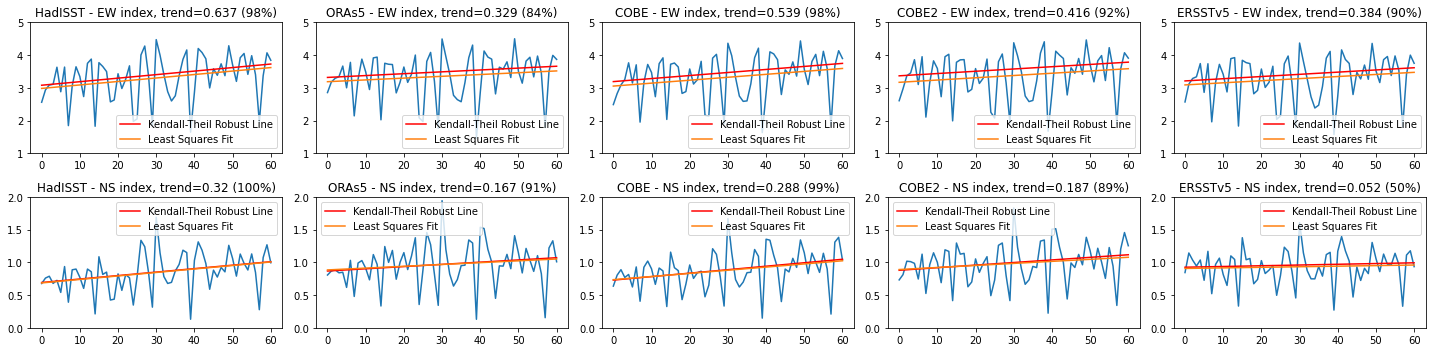

In [5]:
#alpha = 0.1; t = 1.296
alpha = 0.05; t = 1.671
#alpha = 0.15; t=1.045
#alpha = 0.20; t=0.848

fig, axs = plt.subplots(2,5,figsize=(20,5))

for j,index in enumerate(['EW','NS']):
    if index=='EW':
        dsss = dss_EW
        vmin=1;vmax=5
    else:
        dsss = dss_NS
        vmin=0;vmax=2
    for i,prod in enumerate(prods):
        ax = axs[j,i]
        print(prod)
        ds = dsss[prod].sel(time=slice('1958-01','2018-12'))

        NT = len(ds.time)
        x = np.arange(0,NT)
        y = ds.sst.values
        ax.plot(x,y)

        # Mann-Kendall Test  
        trend, h, p, z, tau, s, var_s, slope, intercept  = mk.original_test(y , alpha = alpha)
        bfl =  intercept + slope * x
        ax.plot(x, bfl , 'r', label='Kendall-Theil Robust Line')
        trend = (NT-1) * slope
        sig_lev = 100*(1-p)
        print(f'Mann-Kendall result: {h}, {trend.round(3)}, {round(sig_lev)}%')

        # Least Squares fit and student's t-test Method

        [b,a] = np.polyfit(x,y,1)
        bfl =  a + b * x
        residual = y - bfl
        ax.plot(x,a + b*x,label='Least Squares Fit')
        ax.set_ylim((vmin,vmax))
        varx = np.sum((x - np.mean(x))**2)
        sig2 = np.sum(residual**2)/(NT-2)
        SE = np.sqrt(sig2/varx)*(NT-1)
        print('confidence interval:',(trend-SE*t).round(3),(trend+SE*t).round(3))
        if (trend >= SE*t) or (trend <= -SE*t) :
            result = True   
        else:
            result = False
        trend_ls = b*(NT-1)
        print('Least Squares and t-test result:',result,trend_ls.round(3))
        ax.legend()
        ax.set_title(f'{prod} - {index} index, trend={trend_ls.round(3)} ({round(sig_lev)}%)')
plt.tight_layout()

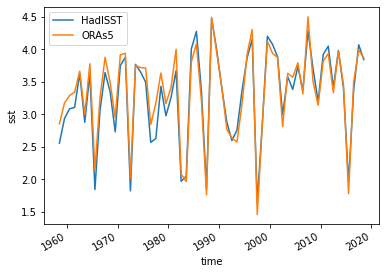

In [6]:
dss_EW['HadISST'].sst.plot(label='HadISST')
dss_EW['ORAs5'].sst.plot(label ='ORAs5')
plt.legend()

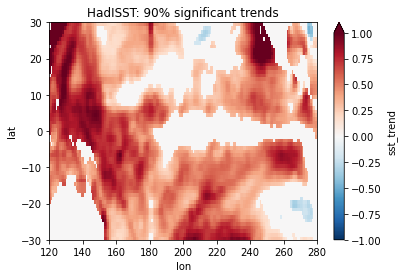

In [7]:
alpha = 0.1; t = 1.296
#alpha = 0.05; t = 1.671
#alpha = 0.15; t=1.045
#alpha = 0.20; t=0.848

sig_lev = round(100*(1- alpha))
prod = 'HadISST'
ds2 = dss[prod].sel(lon=slice(120,280),lat=slice(-30,30))
NT = len(ds2.time)
dfit = ds2.sst.polyfit('time', 1, skipna=True)   # time is in nanoseconds
ds2['sst_fit'] = xr.polyval(coord=ds2.time, coeffs=dfit.polyfit_coefficients)
ds2['sst_trend'] = (ds2.sst_fit[-1] - ds2.sst_fit[0]).where(ds2.sst_fit[0])
ds2['residual'] = ds2.sst - ds2.sst_fit
ds2['time'] = np.arange(0,NT)
xp = ds2.time - ds2.time.mean()
varx = np.square(xp).mean()*NT
sig2 = np.square(ds2.residual).mean(['time'])*NT/(NT-2)
SE = np.sqrt(sig2/varx)*(NT-1)
mask1 = ds2.sst_trend.where(ds2.sst_trend + SE*t < 0,other=0) # significant negative trends
mask2 = ds2.sst_trend.where(ds2.sst_trend - SE*t > 0,other=0) # significant positive trends
(mask1+mask2).plot(vmin=-1,vmax=1,cmap='RdBu_r')
plt.title(f'{prod}: {sig_lev}% significant trends');

In [8]:
# Check first,last times and units
alpha = 0.1; t = 1.296
sig_lev = round(100*(1- alpha))

url = {}
# These must all be monthly datasets!!
url['HadISST'] = 'http://kage.ldeo.columbia.edu:81/home/.datasets/.HadISST/.HadISST_sst.nc/.sst/dods'
url['ORAs5'] = 'http://kage.ldeo.columbia.edu:81/home/.datasets/.ORAs5/.ingrid-ready/.sst.nc/.sst/dods'
url['COBE'] = 'http://kage.ldeo.columbia.edu:81/home/.datasets/.COBE-SST/.sst.mon.mean.nc/.sst/dods'
url['COBE2']= 'http://kage.ldeo.columbia.edu:81/home/.datasets/.COBE-SST2/.sst.mon.mean.nc/.sst/dods'
url['ERSSTv5'] = 'http://kage.ldeo.columbia.edu:81/home/.datasets/.ERSST/.ERSSTv5.nc/.sst/zlev/removeGRID/dods'
start = {'HadISST':1870,'ORAs5':1958,'COBE':1891,'COBE2':1850,'ERSSTv5':1854}

prods = url.keys()
dss = {}
for prod in prods:
    dss[prod] = load(url[prod],start[prod]).sel(time=slice('1958-01','2018-12')).coarsen(time=12,boundary='trim').mean()

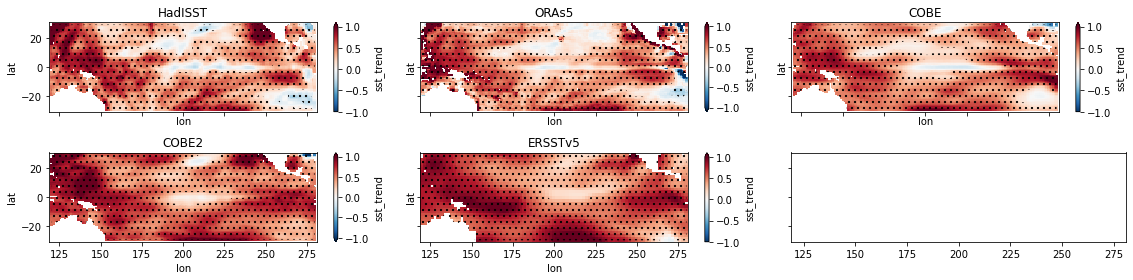

In [9]:
sig_lev = round(100*(1- alpha))
fig, axs = plt.subplots(2,3,figsize=(16,4),sharex=True, sharey=True)
for j,prod in enumerate(prods):
    i = j%3
    k = int(j/3)
    #print(prod)
    ax = axs[k,i]
    ds2 = dss[prod].sel(lon=slice(120,280),lat=slice(-30,30))
    NT = len(ds2.time)
    dfit = ds2.sst.polyfit('time', 1, skipna=True)   # time is in nanoseconds
    ds2['sst_fit'] = xr.polyval(coord=ds2.time, coeffs=dfit.polyfit_coefficients)
    ds2['sst_trend'] = (ds2.sst_fit[-1] - ds2.sst_fit[0]).where(ds2.sst_fit[0])
    ds2['residual'] = ds2.sst - ds2.sst_fit
    ds2['time'] = np.arange(0,NT)
    xp = ds2.time - ds2.time.mean()
    varx = np.square(xp).mean()*NT
    sig2 = np.square(ds2.residual).mean(['time'])*NT/(NT-2)
    SE = np.sqrt(sig2/varx)*(NT-1)
    mask1 = ds2.sst_trend.where(ds2.sst_trend + SE*t < 0,other=0) # significant negative trends
    mask2 = ds2.sst_trend.where(ds2.sst_trend - SE*t > 0,other=0) # significant positive trends    
    ds2.sst_trend.plot(ax=ax,vmin=-1,vmax=1,cmap='RdBu_r')
    (mask1+mask2).plot.contourf(ax=ax,levels=[-.0001,.0001],colors='none',hatches=['..',None],extend='both',add_colorbar=0)
    ax.set_title(f'{prod}')
plt.tight_layout()

CMIP6-MMM
LENS-CESM1-CAM5
LENS-CSIRO-Mk3-6-0
LENS-CanESM2
LENS-GFDL-CM3
LENS-GFDL-ESM2M
LENS-MMM
LENS-MPI-ESM


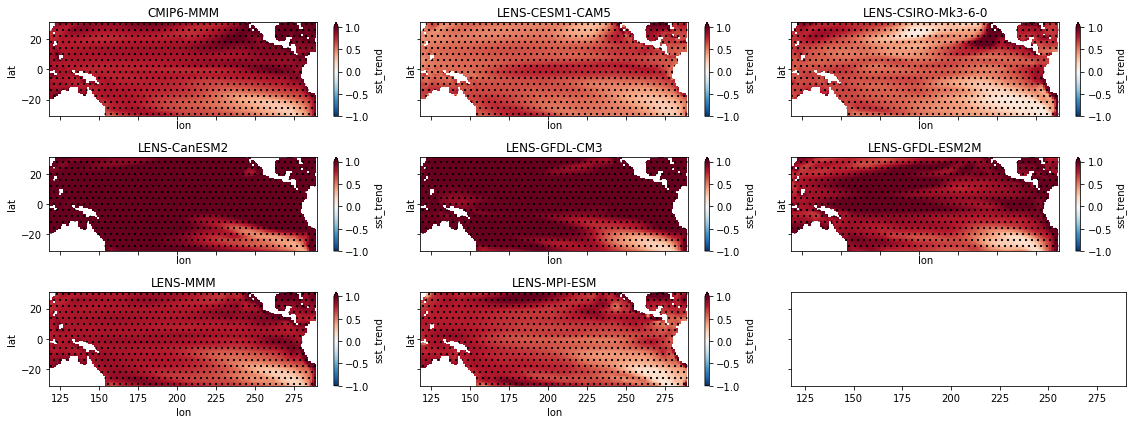

In [16]:
alpha = 0.1; t = 1.296
#alpha = 0.05; t = 1.671
#alpha = 0.15; t=1.045
#alpha = 0.20; t=0.848

sig_lev = round(100*(1- alpha))
path = '/net/carney/d1/naomi/TCC-enso/TPCC-revision/data-TP'
files = sorted(glob(f'{path}/CMIP6*_ts.nc')) + sorted(glob(f'{path}/LENS*_ts.nc'))
fig, axs = plt.subplots(3,3,figsize=(16,6),sharex=True, sharey=True)
for j,file in enumerate(files):
    i = j%3
    k = int(j/3)
    prod = file.split('data-TP/')[-1].split('_ts.nc')[0]
    print(prod)
    ax = axs[k,i]
    ds2 = xr.open_dataset(file)
    NT = len(ds2.time)
    dfit = ds2.ts.polyfit('time', 1, skipna=True)   # time is in nanoseconds
    ds2['sst_fit'] = xr.polyval(coord=ds2.time, coeffs=dfit.polyfit_coefficients)
    ds2['sst_trend'] = (ds2.sst_fit[-1] - ds2.sst_fit[0]).where(ds2.sst_fit[0])
    ds2['residual'] = ds2.ts - ds2.sst_fit
    ds2['time'] = np.arange(0,NT)
    xp = ds2.time - ds2.time.mean()
    varx = np.square(xp).mean()*NT
    sig2 = np.square(ds2.residual).mean(['time'])*NT/(NT-2)
    SE = np.sqrt(sig2/varx)*(NT-1)
    mask1 = ds2.sst_trend.where(ds2.sst_trend + SE*t < 0,other=0) # significant negative trends
    mask2 = ds2.sst_trend.where(ds2.sst_trend - SE*t > 0,other=0) # significant positive trends
    ds2.sst_trend.plot(ax=ax,vmin=-1,vmax=1,cmap='RdBu_r')
    (mask1+mask2).plot.contourf(ax=ax,levels=[-.0001,.0001],colors='none',hatches=['..',None],extend='both',add_colorbar=0)
    ax.set_title(f'{prod}')
plt.tight_layout()

In [17]:
path = '/net/carney/d1/naomi/TCC-enso/TPCC-revision/data-TP'
files = sorted(glob(f'{path}/CMIP6*_ts.nc')) + sorted(glob(f'{path}/LENS*_ts.nc'))

for file in files:
    ds2 = xr.open_dataset(file)
    prod = file.split('data-TP/')[-1].split('_ts.nc')[0]
    print(f'\n{prod}, EW index')
    dW = ds2.sel(lon= slice(xEW_W1,xEW_E1),lat=slice(-yWE,yWE)).mean(['lon','lat'])
    dE = ds2.sel(lon= slice(xEW_W2,xEW_E2),lat=slice(-yWE,yWE)).mean(['lon','lat'])
    NT = len(ds2.time)
    x = np.arange(0,NT)
    y = -(dE-dW).ts.values
    # Mann-Kendall Test  
    trend, h, p, z, tau, s, var_s, slope, intercept  = mk.original_test(y , alpha = alpha)
    bfl =  intercept + slope * x
    trend = (NT-1) * slope
    sig_lev = 100*(1-p)
    print(f'Mann-Kendall result: {h}, {trend.round(3)}, {round(sig_lev)}%')


CMIP6-MMM, EW index
Mann-Kendall result: True, -0.066, 98%

LENS-CESM1-CAM5, EW index
Mann-Kendall result: True, -0.14, 99%

LENS-CSIRO-Mk3-6-0, EW index
Mann-Kendall result: False, 0.053, 54%

LENS-CanESM2, EW index
Mann-Kendall result: True, -0.169, 100%

LENS-GFDL-CM3, EW index
Mann-Kendall result: True, -0.181, 99%

LENS-GFDL-ESM2M, EW index
Mann-Kendall result: False, 0.085, 62%

LENS-MMM, EW index
Mann-Kendall result: False, -0.007, 17%

LENS-MPI-ESM, EW index
Mann-Kendall result: True, 0.152, 100%


In [18]:
for file in files:
    ds2 = xr.open_dataset(file)
    prod = file.split('data-TP/')[-1].split('_ts.nc')[0]
    print(f'\n{prod}, NS index')
    dS = ds2.sel(lon=slice(xNS_W,xNS_E),lat=slice(-yNS_N,-yNS_Eq)).mean(['lon','lat'])
    dN = ds2.sel(lon=slice(xNS_W,xNS_E),lat=slice( yNS_Eq, yNS_N)).mean(['lon','lat'])
    dEQ = ds2.sel(lon=slice(xNS_W,xNS_E),lat=slice(-yNS_Eq, yNS_Eq)).mean(['lon','lat'])
    NT = len(ds2.time)
    x = np.arange(0,NT)
    y = (0.5*(dS + dN) - dEQ).ts.values
    ax.plot(x,y)

    # Mann-Kendall Test  
    trend, h, p, z, tau, s, var_s, slope, intercept  = mk.original_test(y , alpha = alpha)
    bfl =  intercept + slope * x
    trend = (NT-1) * slope
    sig_lev = 100*(1-p)
    print(f'Mann-Kendall result: {h}, {trend.round(3)}, {round(sig_lev)}%')


CMIP6-MMM, NS index
Mann-Kendall result: False, 0.007, 32%

LENS-CESM1-CAM5, NS index
Mann-Kendall result: True, -0.089, 99%

LENS-CSIRO-Mk3-6-0, NS index
Mann-Kendall result: False, -0.034, 87%

LENS-CanESM2, NS index
Mann-Kendall result: True, -0.185, 100%

LENS-GFDL-CM3, NS index
Mann-Kendall result: False, -0.025, 40%

LENS-GFDL-ESM2M, NS index
Mann-Kendall result: False, -0.062, 79%

LENS-MMM, NS index
Mann-Kendall result: True, -0.049, 99%

LENS-MPI-ESM, NS index
Mann-Kendall result: False, 0.029, 89%
